<a href="https://colab.research.google.com/github/nasr98/DOC-CNN/blob/main/CNN_DOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Document Classification

In [15]:
!pip install opencv-python
!pip install opendatasets
!pip3 install ann_visualizer
!pip install graphviz

In [16]:
import tensorflow as tf
import numpy as np
import pandas as pd
import opendatasets as op
import cv2 as cv
import ann_visualizer as an
import graphviz as gv
import pathlib
import os
import keras

## Data Preparation

### Download Dataset

In [17]:
import shutil
op.download("https://www.kaggle.com/datasets/pdavpoojan/the-rvlcdip-dataset-test")
# try:
#   shutil.rmtree("/content/the-rvlcdip-dataset-test/test/scientific_publication")
# except FileNotFoundError:
#   print('Skip')

Skipping, found downloaded files in ".\the-rvlcdip-dataset-test" (use force=True to force download)


In [18]:
cv.imread('the-rvlcdip-dataset-test/test/advertisement/00001014.tif').shape


(1000, 754, 3)


### Prepare Tensor Dataset

In [19]:
data_dir = 'the-rvlcdip-dataset-test/test'

def create_dataset(path):
  dir_list = [x for x in os.listdir(path)]
  dir_enum = {x:dir_list.index(x)+1 for x in dir_list}
  print(dir_enum)
  master = []
  label = []
  for x in dir_list:
    try:
      print(x)
      spec_path = path+'/'+x
      
      #Setting image size to 32,32, color to grey and normalize pixels
      img = [tf.image.resize(cv.imread(spec_path + '/' +y), tf.constant([32, 32]))/255.0 for y in os.listdir(spec_path) if np.shape(cv.imread(spec_path + '/' +y)) != ()]
      labels = [dir_enum[x] for y in img]
      #extend master list with images and labels
      master.extend(img)
      label.extend(labels)
      del img
      del labels
    except TypeError:
      print(x)
  #Organize data in df
  t_df = pd.DataFrame(list(zip(label,master)),columns=['label','image'])
  #Convert DF to DS
  # t_ds = tf.data.Dataset.from_tensor_slices((list(t_df['image'].values), t_df['label'].values))
  return t_df,dir_enum

In [20]:
if os.path.exists("./rvlcdip.pkl"):
  df = pd.read_pickle("./rvlcdip.pkl")
else:
  df,dir_enum = create_dataset(data_dir)
  df.to_pickle("./rvlcdip.pkl")

{'advertisement': 1, 'budget': 2, 'email': 3, 'file_folder': 4, 'form': 5, 'handwritten': 6, 'invoice': 7, 'letter': 8, 'memo': 9, 'news_article': 10, 'presentation': 11, 'questionnaire': 12, 'resume': 13, 'scientific_publication': 14, 'scientific_report': 15, 'specification': 16}
advertisement
budget
email
file_folder
form
handwritten
invoice
letter
memo
news_article
presentation
questionnaire
resume
scientific_publication
scientific_report
specification


In [21]:
df['image'][0].shape

TensorShape([32, 32, 3])

In [22]:
ds = tf.data.Dataset.from_tensors((list(df['image'].values), df['label'].values))
ds

<TensorDataset element_spec=(TensorSpec(shape=(39996, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(39996,), dtype=tf.int64, name=None))>

## EDA

### Sample Images

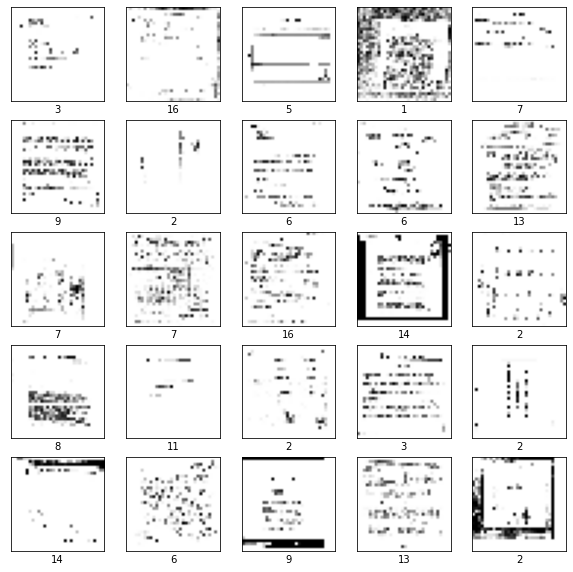

In [23]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

plt.figure(figsize=(10,10))
df1 = df.sample(frac=1).reset_index(drop=True)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(df1['image'][i])
    plt.xlabel(df1['label'][i])


### Images by label

<AxesSubplot:>

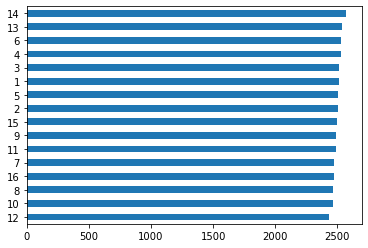

In [24]:
df['label'].value_counts().sort_values().plot(kind = 'barh',)

## Architecture Definition

### Convolution Base

In [71]:
df['image'][0].shape

TensorShape([32, 32, 3])

In [72]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3))) # input layer

#hidden layer#
model.add(tf.keras.layers.MaxPooling2D((2, 2))) 
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
#############

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu')) # output layer

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-trai

### Dense Layers

In [73]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(17))

In [74]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_5 (Flatten)         (None, 1024)             

### Architecture Viz

In [75]:
# from ann_visualizer.visualize import ann_viz
# ann_viz(model, view=True, title="DOC CNN", filename='./doccnn.gv')

## Training: First iteration

#### Splitting into Train,Test,Val

In [76]:
# DATASET_SIZE = ds.cardinality().numpy()
# train_size = int(0.7 * DATASET_SIZE)
# test_size = int(0.15 * DATASET_SIZE)
# val_size = int(0.15 * DATASET_SIZE)

In [77]:
trainset = ds.shard(2, 0)
testset = ds.shard(2, 1)

In [78]:
# train = train.shuffle(1000).batch(32)
# test = test.shuffle(1000).batch(32)
# val = val.shuffle(1000).batch(32)

#### Compilation/Training

In [87]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],run_eagerly=True,)

In [88]:
tf.config.run_functions_eagerly(True)
# train_Y, train_X = tuple(zip(*train))
history = model.fit(trainset,epochs=40,validation_data=testset)


Epoch 1/40
1/1 [==============================] - 21s 21s/step - loss: 2.6160 - accuracy: 0.1701
Epoch 2/40
1/1 [==============================] - 17s 17s/step - loss: 2.6616 - accuracy: 0.0881
Epoch 3/40
1/1 [==============================] - 17s 17s/step - loss: 2.5856 - accuracy: 0.1600
Epoch 4/40
1/1 [==============================] - 17s 17s/step - loss: 2.6108 - accuracy: 0.1396
Epoch 5/40
1/1 [==============================] - 16s 16s/step - loss: 2.6121 - accuracy: 0.1336
Epoch 6/40
1/1 [==============================] - 17s 17s/step - loss: 2.5827 - accuracy: 0.1623
Epoch 7/40
1/1 [==============================] - 17s 17s/step - loss: 2.5620 - accuracy: 0.1846
Epoch 8/40
1/1 [==============================] - 16s 16s/step - loss: 2.5763 - accuracy: 0.1430
Epoch 9/40
1/1 [==============================] - 16s 16s/step - loss: 2.5481 - accuracy: 0.1788
Epoch 10/40
1/1 [==============================] - 16s 16s/step - loss: 2.5222 - accuracy: 0.1844
Epoch 11/40
1/1 [============